In [1]:
import os 
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


2025-06-08 18:13:35.946976: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749406416.132896      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749406416.187485      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BASE_DIR='/kaggle/input/flickr8k'
WORKING_DIR='/kaggle/working'    

In [3]:
# Load and modify InceptionV3 model
inception_model = InceptionV3(weights='imagenet')
model = Model(inputs=inception_model.input, outputs=inception_model.get_layer('avg_pool').output)
print(model.summary())


I0000 00:00:1749406438.043806      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749406438.044538      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

None


In [4]:
# Extract features from images using InceptionV3
features = {}
directory = os.path.join(BASE_DIR, 'Images')
for img_name in tqdm(os.listdir(directory)):
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size=(299, 299))  # Required for InceptionV3
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature


  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1749406463.002502      96 service.cc:148] XLA service 0x79f8c40043c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749406463.003018      96 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749406463.003038      96 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749406463.952277      96 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749406468.422496      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [5]:
with open(os.path.join(BASE_DIR,'captions.txt'),'r') as f:
    next(f)
    captions_doc=f.read()

In [6]:

# Create mapping from image ID (without .jpg) to captions
mapping = {}

for line in tqdm(captions_doc.strip().split('\n')):
    tokens = line.strip().split(',')
    if len(tokens) < 2:
        continue

    image_id = tokens[0].strip().split('.')[0]  # Remove .jpg and strip spaces
    caption = " ".join(tokens[1:]).strip()  # Join caption parts and strip

    if image_id not in mapping:
        mapping[image_id] = []

    mapping[image_id].append(caption)




  0%|          | 0/40455 [00:00<?, ?it/s]

In [7]:
len(mapping)

8091

In [8]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [9]:
def clean(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)):
            #take one caption at atime
            caption=captions[i]
            #preprocessing
            caption=caption.lower()
            #replace digits ,specail characters
            caption=caption.replace('[^A-Za-z]','')
            #delete extra space
            caption=caption.replace('\s+',' ')
            #add start and end
            caption ='<start> ' + " ".join([word for word in caption.split() if len(word)>1]) + ' <end>'
            captions[i]=caption

In [10]:
clean(mapping)

In [11]:
mapping['1001773457_577c3a7d70']

['<start> black dog and spotted dog are fighting <end>',
 '<start> black dog and tri-colored dog playing with each other on the road <end>',
 '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start> two dogs of different breeds looking at each other on the road <end>',
 '<start> two dogs on pavement moving toward each other <end>']

In [12]:
all_captions=[]
for key in mapping:
     for caption in mapping[key]:
         all_captions.append(caption)

In [13]:
len(all_captions)

40455

In [14]:
all_captions[:10]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>',
 '<start> black dog and spotted dog are fighting <end>',
 '<start> black dog and tri-colored dog playing with each other on the road <end>',
 '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start> two dogs of different breeds looking at each other on the road <end>',
 '<start> two dogs on pavement moving toward each other <end>']

In [15]:
tokenizer = Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(all_captions)

vocab_size = len(tokenizer.word_index) + 1


In [16]:
import pickle

# Save the tokenizer to a file
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [17]:
vocab_size

8484

In [18]:
#get maximum length of the caption 

max_length=max(len(caption.split()) for caption in all_captions)
max_length

35

In [19]:
#train test split

image_ids=list(mapping.keys())
split=int(len(image_ids) * 0.90)
train=image_ids[:split]
test=image_ids[split:]


In [20]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for key in data_keys:
            captions = mapping[key]
            for caption in captions:
                caption = '<start> ' + caption.strip() + ' <end>'
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])  # shape: (2048,)
                    X2.append(in_seq)            # shape: (max_length,)
                    y.append(out_seq)            # shape: (vocab_size,)
                    n += 1

                    if n == batch_size:
                        yield ((np.array(X1), np.array(X2)), np.array(y))
                        X1, X2, y = list(), list(), list()
                        n = 0


In [21]:
import tensorflow as tf

# Use the correct feature_dim
feature_dim = 2048

dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, feature_dim), dtype=tf.float32),   # image features
            tf.TensorSpec(shape=(None, max_length), dtype=tf.int32),      # input sequences
        ),
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)         # output (one-hot)
    )
)


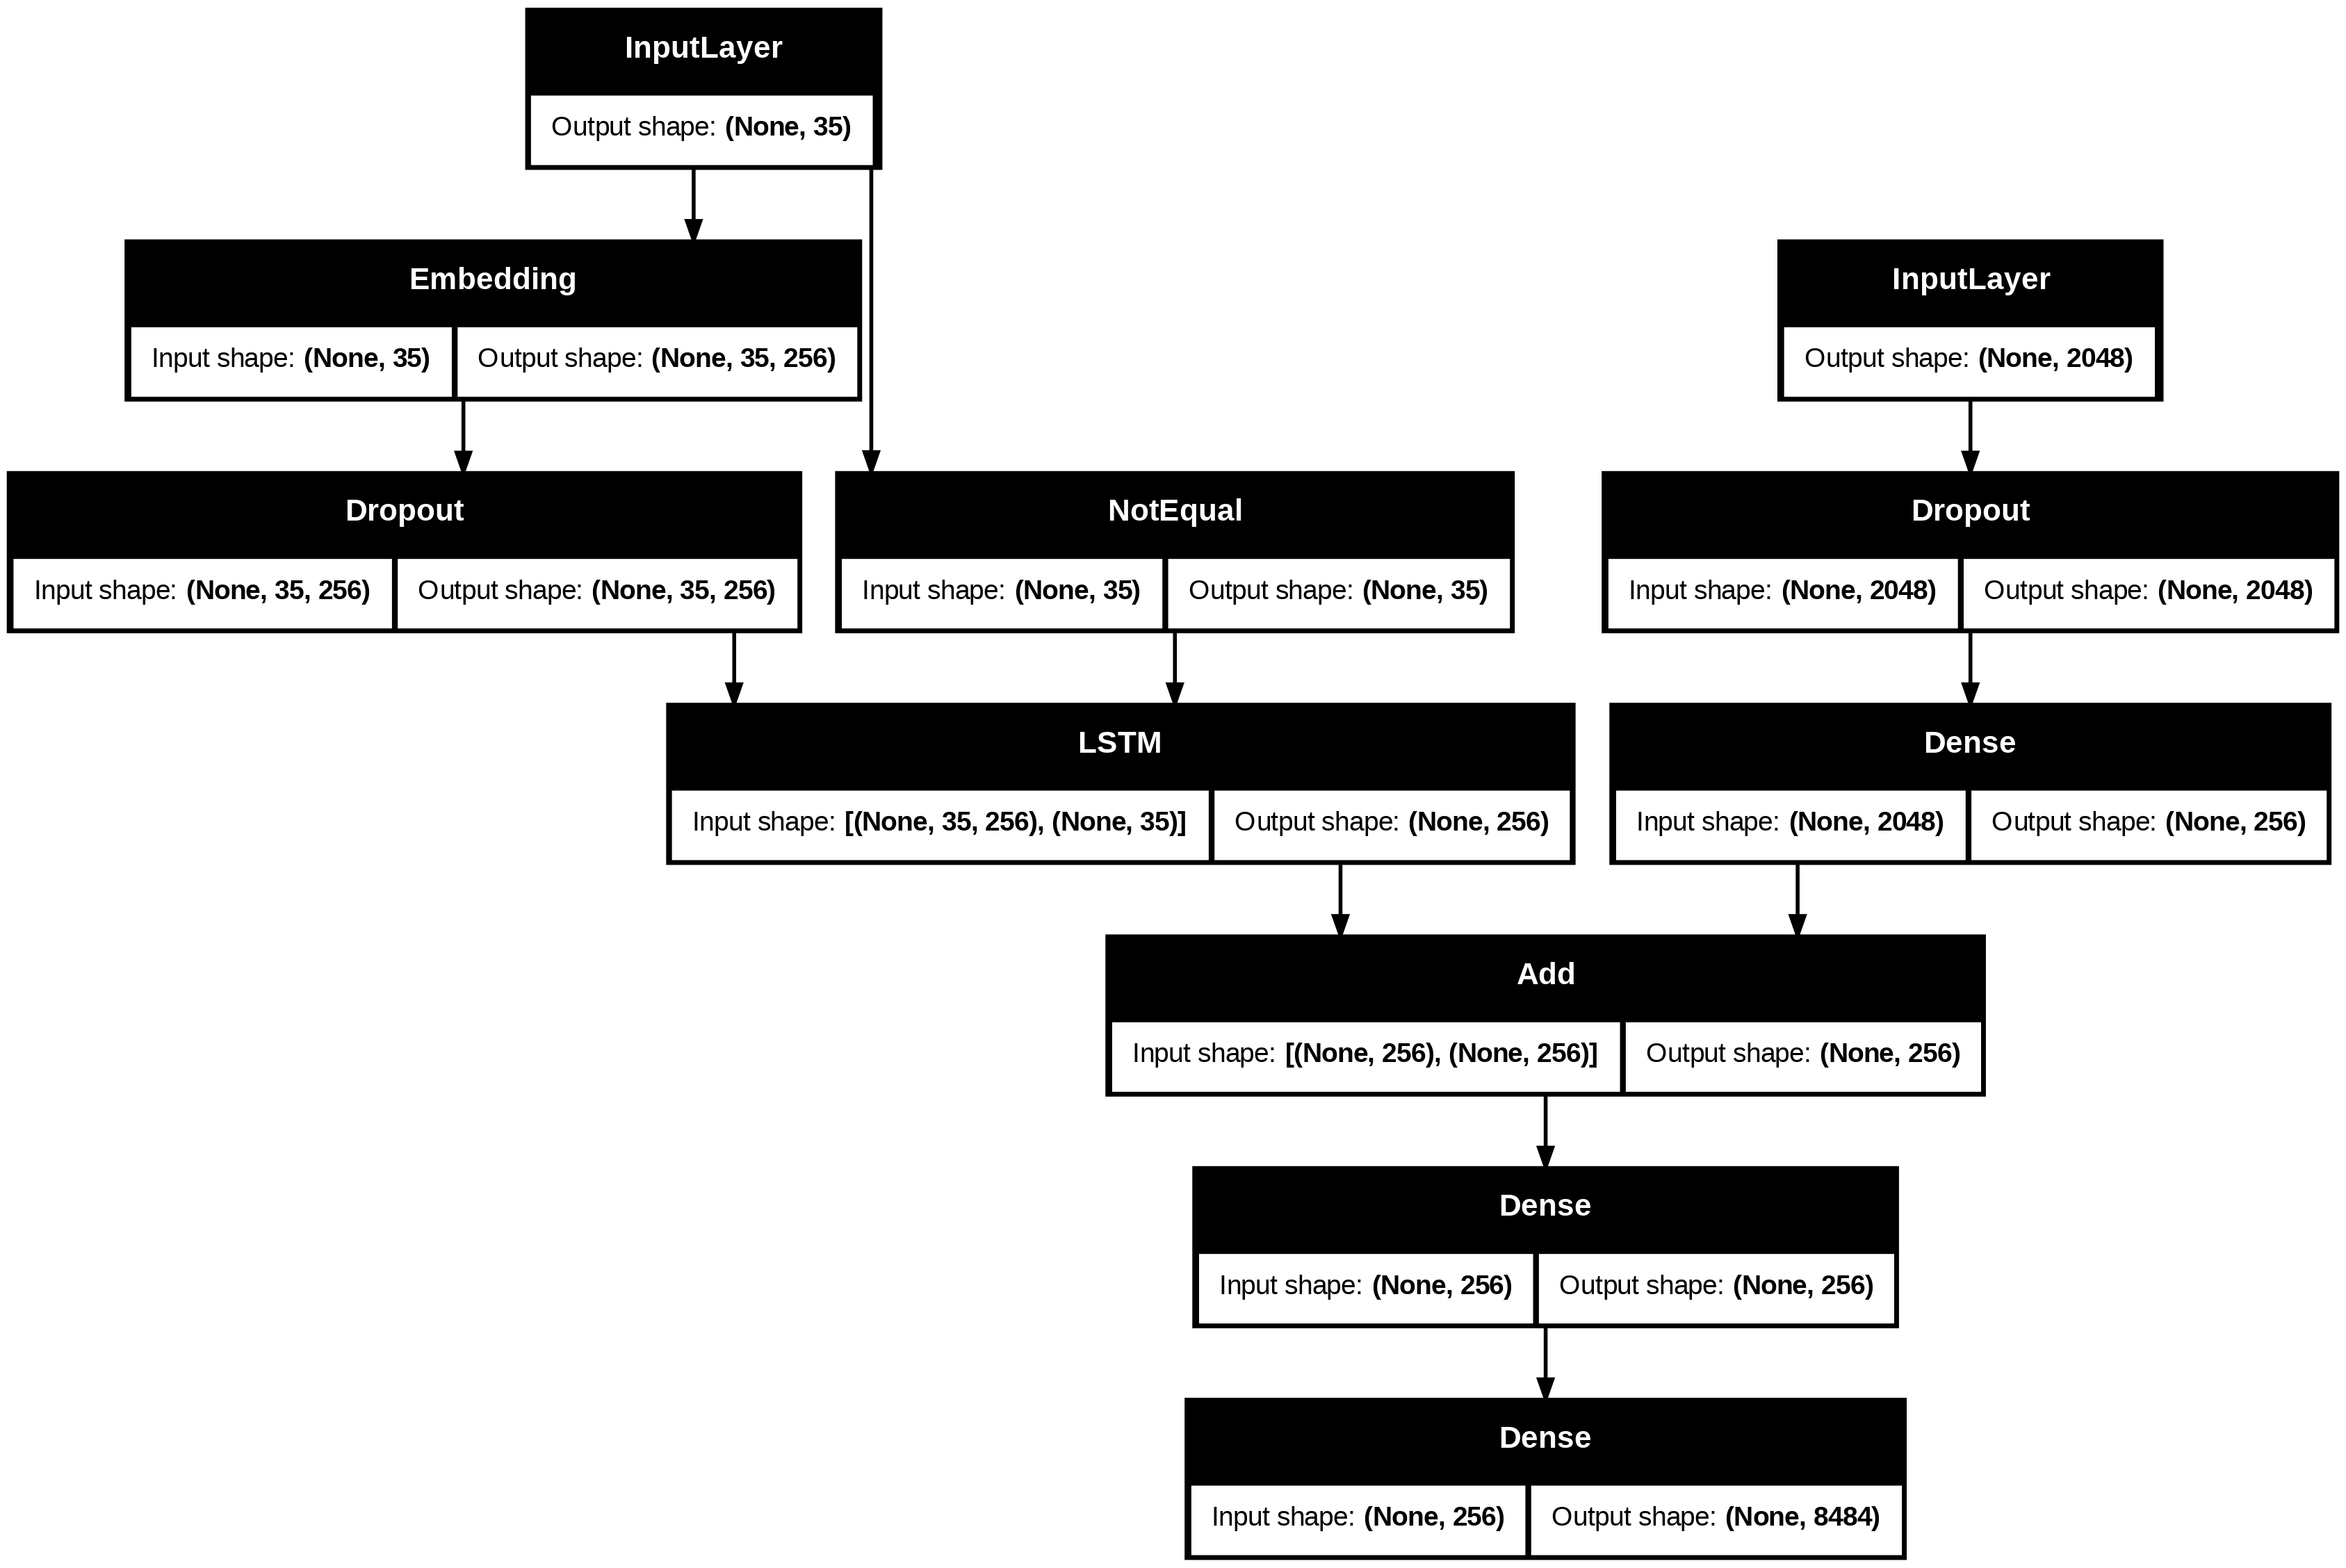

In [22]:
#model creation
inputs1=Input(shape=(2048,))
fe1=Dropout(0.4)(inputs1)
fe2=Dense(256,activation='relu')(fe1)
#sequence layer
inputs2=Input(shape=(max_length,))
se1=Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2=Dropout(0.4)(se1)
se3=LSTM(256)(se2)
#decoder 
decoder1=add([fe2,se3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

model=Model(inputs=[inputs1,inputs2],outputs=outputs)

model.compile(loss='categorical_crossentropy',optimizer='adam')

#plot the moel
plot_model(model,show_shapes=True)

In [23]:
# Set parameters
epochs = 100
batch_size = 64
steps_per_epoch = len(train) // batch_size

# Train the model
model.fit(
    dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    verbose=1
)


Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 6.5032
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.8778
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6845
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.5163
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.3148
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.3556
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.2833
Epoch 8/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4444
Epoch 9/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.0747
Epoch 10/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.0258
Epoch 11/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.9410
Epoch 12/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.9003
Epoch 13/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.7441
Epoch 14/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.6557
Epoch 15/100
113/113 ━━━━━━━━━━━━━━━━━━━━

In [28]:
model.save('best_model.h5')

In [24]:
model.save('best_model.keras')

In [25]:
#generate caption for thr image

def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [26]:
import re
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_caption(model, image, tokenizer, max_length):
    in_text = ['<start>']  # list of tokens instead of string
    
    for _ in range(max_length):
        # Convert current token list to string and then to sequence
        sequence = tokenizer.texts_to_sequences([' '.join(in_text)])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        
        # Predict next word
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        
        if word is None:
            break
        
        # Stop if end token predicted
        if word.lower() in ['<end>', 'end']:
            break
        
        in_text.append(word)  # append predicted word to list

    # Convert tokens list to final sentence string
    final_caption = ' '.join(in_text)
    final_caption = final_caption.replace('<start>', '').replace('<end>', '')
    final_caption = re.sub(r'\bend\b', '', final_caption, flags=re.IGNORECASE)
    final_caption = re.sub(r'\s+', ' ', final_caption).strip()
    
    return final_caption


In [27]:
#validate with test data
from nltk.translate.bleu_score import corpus_bleu

actual, predicted =list(),list()
for key in tqdm(test):
    captions=mapping[key]
    y_pred=predict_caption(model, features[key],tokenizer,max_length)
    actual_captions=[caption.split() for caption in captions]
    y_pred=y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

#calculate BLEU score
print("BLEU-1: %f"% corpus_bleu(actual,predicted,weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f"% corpus_bleu(actual,predicted,weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.353940
BLEU-2: 0.175197


In [28]:
#visualize the result

from PIL import Image
import matplotlib.pyplot as plt


#load the image
def generate_caption(image_name):
    
    
    image_id=image_name.split('.')[0]
    img_path=os.path.join(BASE_DIR,"Images", image_name)
    image=Image.open(img_path)

    captions=mapping[image_id]
    print('--------------------actual-----------------------')
    for caption in captions:
        print(caption)
    y_pred=predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------predict------------------------')
    
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    print(y_pred)

--------------------actual-----------------------
<start> child in pink dress is climbing up set of stairs in an entry way <end>
<start> girl going into wooden building <end>
<start> little girl climbing into wooden playhouse <end>
<start> little girl climbing the stairs to her playhouse <end>
<start> little girl in pink dress going into wooden cabin <end>
--------------------predict------------------------


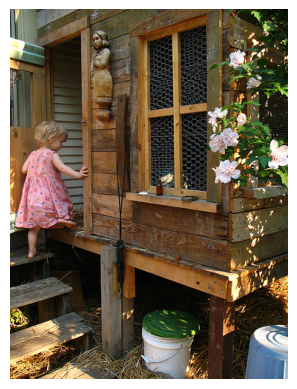

start man in black shirt and black shirt is standing in the air


In [29]:
generate_caption("1000268201_693b08cb0e.jpg")